# Eigenfaces v.s. Fisherfaces

a. eigenface : Using PCA for dimensionality reduction
    - Disadvantage : 분산이 커다란 쪽으로 방향을 정하는데, 빛이나 얼굴표정에 따라서 원치않는 분산이 생김. 
    *** Within Class Scatter > Between Class Scatter
   
b. Fisherface : Simple fact that same classes should cluster tigthly together, while different classes are as far away as possible from each other

In [1]:
%matplotlib inline

from time import time
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import glob
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
def load_images_from_folder(path):
    fileList = glob.glob(path + '*.jpg')
    images = []
    
    for filepath in fileList:
        img = cv2.imread(filepath)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        images.append(gray)
        
    return images

In [3]:
# Class 0
images1 = load_images_from_folder('./pictures/1-1/')
images1 = np.asarray(images1)

# Class 1
images2 = load_images_from_folder('./pictures/2-1/')
images2 = np.asarray(images2)

# Class 2
images3 = load_images_from_folder('./pictures/3-1/')
images3 = np.asarray(images3)

# Class 3
images4 = load_images_from_folder('./pictures/4-1/')
images4 = np.asarray(images4)

In [4]:
images1.shape[0], images2.shape[0], images3.shape[0], images4.shape[0]

(39, 39, 40, 39)

In [5]:
images = np.vstack([images1, images2, images3, images4])

In [6]:
n_samples, h, w = images.shape
n_samples, h, w

(157, 70, 70)

In [7]:
# Define X
X = images.reshape(157, -1)
n_features = X.shape[1]
X.shape

(157, 4900)

In [8]:
# Define y value
y1 = np.zeros(39,)
y2 = np.ones(39,)
y3 = np.ones(40,) * 2
y4 = np.ones(39,) * 2 + 1

y = np.hstack([y1, y2, y3, y4])
y.shape

(157,)

In [9]:
# Define target names
target_names = np.array(['Jung Yumi', 'Shin Hye-sun', 'Gong Hyojin', 'Lee Yubi'])
n_classes = target_names.shape[0]
n_classes

4

In [10]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 157
n_features: 4900
n_classes: 4


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

### Eigenfaces

In [12]:
# compute a PCA(eigenfaces) on the face dataset (treated as unlabeled)
# dataset ; unsupervised feature extraction / dimensionality reduction

n_components = 33
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
# 좌표 변환
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 33 eigenfaces from 117 faces
done in 0.249s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.270s


In [13]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 0.262s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [14]:
# Qualitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.001s
              precision    recall  f1-score   support

   Jung Yumi       0.88      0.78      0.82         9
Shin Hye-sun       0.78      0.78      0.78         9
 Gong Hyojin       0.73      0.89      0.80         9
    Lee Yubi       0.92      0.85      0.88        13

 avg / total       0.83      0.82      0.83        40

[[ 7  1  0  1]
 [ 0  7  2  0]
 [ 1  0  8  0]
 [ 0  1  1 11]]


In [15]:
# Qualititative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [16]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


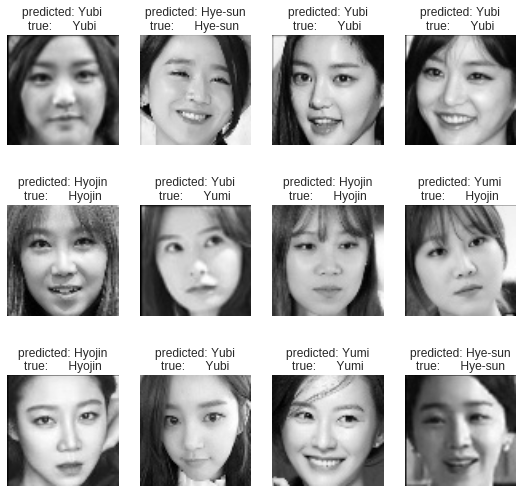

In [17]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                    for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

In [ ]:
eigenfaces.shape

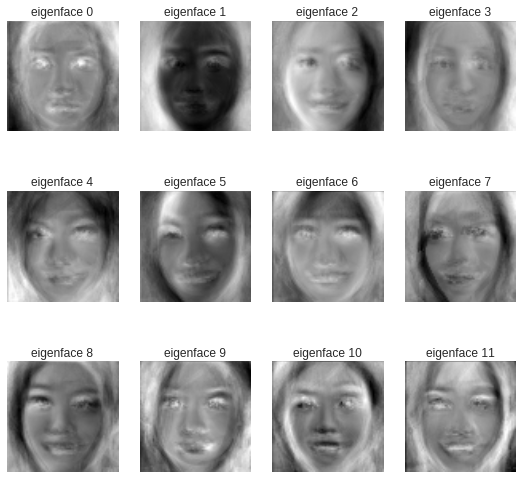

In [18]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

### Calculate Distance
 - E